# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import boto3
from sagemaker import get_execution_role
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from sklearn.model_selection import cross_val_score, cross_val_predict
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV


# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [4]:
# load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

# retrieve the IAM role
role = get_execution_role()

# bucket name
bucket='udacity-arvato-capstoneproject'
#data_keys
data_key_azdias = 'Udacity_AZDIAS_052018.csv'
data_key_customers = 'Udacity_CUSTOMERS_052018.csv'
#data_locations
data_location_azdias = 's3://{}/{}'.format(bucket, data_key_azdias)
data_location_customers = 's3://{}/{}'.format(bucket, data_key_customers)

azdias = pd.read_csv(data_location_azdias, sep=';',low_memory=False)
customers = pd.read_csv(data_location_customers, sep=';',low_memory=False)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [5]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
azdias.shape

(891221, 366)

In [7]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [8]:
customers.shape

(191652, 369)

# EDA

In [9]:
run_comparison_plots_eda = False


azdias_len = len(azdias)
customers_len = len(customers)
interest_variables = []

for col in azdias.columns:
    
    if col not in ['LNR', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR']:
        
        #AZDIAS - general population
        azdiaz_groups = azdias.groupby([col]).agg({'LNR':'count'}).reset_index().rename(columns={'LNR': 'count'})            
        azdiaz_groups['proportion'] = azdiaz_groups['count']/azdias_len
        #customers
        customers_groups = customers.groupby([col]).agg({'LNR':'count'}).reset_index().rename(columns={'LNR': 'count'})
        customers_groups['proportion'] = customers_groups['count']/customers_len
        # join
        join_comparison = azdiaz_groups.merge(customers_groups, how='left', on=col, suffixes=('_general_population', '_customers'))
        join_comparison['diff'] = join_comparison['proportion_customers'] - join_comparison['proportion_general_population']
        max_diff = join_comparison['diff'].max()

        if max_diff > 0.2:
            
            print('variable of interest: {}'.format(col))
            interest_variables.append(col)
            # melt DataFrame to long format
            df_melt = pd.melt(join_comparison, id_vars=[col], value_vars=['proportion_general_population', 'proportion_customers'], var_name='Group', value_name='proportion')
            
            if run_comparison_plots_eda == True:
                #Distribution plots comparison
                fig, ax = plt.subplots()
                sns.barplot(data=df_melt, x=col, y='proportion', hue='Group')
                # assign legend outside plot
                ax.legend(title='', loc='upper left', bbox_to_anchor=(1, 1))
                plt.show()

                if col == 'FINANZ_SPARER':
                    fig.savefig('FINANZ_SPARER.png', bbox_inches='tight')

variable of interest: CJT_KATALOGNUTZER
variable of interest: CJT_TYP_2
variable of interest: CJT_TYP_3
variable of interest: CJT_TYP_4
variable of interest: CJT_TYP_5
variable of interest: CJT_TYP_6
variable of interest: D19_KONSUMTYP
variable of interest: D19_KONSUMTYP_MAX
variable of interest: D19_SOZIALES
variable of interest: FINANZ_ANLEGER
variable of interest: FINANZ_MINIMALIST
variable of interest: FINANZ_SPARER
variable of interest: FINANZ_VORSORGER
variable of interest: HH_EINKOMMEN_SCORE
variable of interest: KOMBIALTER
variable of interest: RT_SCHNAEPPCHEN
variable of interest: SEMIO_ERL


### Clean columns for which we have the variables in the provided excel dictionary

In this part of the code, those columns that dont appear in the excel file providad with the explanation of the variables are removed

In [10]:
with open('list_in_dict.pkl', 'rb') as f:
    cols_to_keep = pickle.load(f)

In [11]:
len(cols_to_keep)

314

### Add vairables of interest to the list "cols_to_keep"

In [12]:
for var in interest_variables:
    if var not in cols_to_keep:
        cols_to_keep.append(var)

In [13]:
len(cols_to_keep)

324

In [14]:
def clean_dias_attributes(df):

    """
    This function filters those columns of interest according to the EDA or also columns that were specified in the dictionary

    Parameters:
    df (dataframe): The dataframe to be filtered.

    Returns:
    df: the clean dataframe
    """
    
    print('Number of fields before: {}'.format(df.shape[1]))
    df_columns = df.columns.tolist()
    common_fields = [elem for elem in df_columns if elem in cols_to_keep]
    # Filter columns using loc accessor
    df = df.loc[:, common_fields]
    print('Number of fields after cleaning : {}'.format(df.shape[1]))

    return df

In [15]:
azdias = clean_dias_attributes(azdias)

Number of fields before: 366
Number of fields after cleaning : 315


### Clean Nans in columns

Count the number of nulls for every column

In [16]:
# read the dictionary from the file
with open('dictionary_nulls.json', 'r') as f:
    nulls_dict = json.load(f)

In [17]:
def replace_unknown_values(df):
    
    # loop through the keys of the dictionary and check if the key exists in the DataFrame columns
    for col_name in nulls_dict.keys():
        if col_name in df.columns:        
            for null_val in nulls_dict.get(col_name):
                df[col_name] = df[col_name].replace(null_val, np.nan)
                
    return df

In [18]:
azdias = replace_unknown_values(azdias)

In [19]:
azdias.shape

(891221, 315)

In [20]:
# count the number of NaNs/nulls for each column
null_counts = azdias.isnull().sum()
null_percentage = null_counts*100/len(azdias)
null_percentage.sort_values(ascending=False, inplace=True)

for index, col in null_percentage.items():
    print('{} - {}%'.format(index, round(col)))

TITEL_KZ - 100%
D19_TELKO_ONLINE_DATUM - 99%
D19_BANKEN_LOKAL - 98%
D19_BANKEN_OFFLINE_DATUM - 98%
D19_TELKO_ANZ_12 - 96%
D19_DIGIT_SERV - 96%
D19_BIO_OEKO - 96%
D19_TIERARTIKEL - 96%
D19_NAHRUNGSERGAENZUNG - 96%
D19_GARTEN - 96%
D19_LEBENSMITTEL - 94%
D19_WEIN_FEINKOST - 94%
D19_BANKEN_ANZ_12 - 93%
D19_ENERGIE - 93%
D19_TELKO_ANZ_24 - 93%
D19_BANKEN_REST - 92%
D19_VERSI_ANZ_12 - 92%
D19_TELKO_OFFLINE_DATUM - 92%
D19_BILDUNG - 91%
D19_BEKLEIDUNG_GEH - 91%
D19_RATGEBER - 90%
D19_SAMMELARTIKEL - 90%
D19_BANKEN_ANZ_24 - 89%
D19_FREIZEIT - 89%
D19_BANKEN_GROSS - 88%
D19_VERSI_ANZ_24 - 87%
D19_SCHUHE - 87%
D19_HANDWERK - 86%
D19_TELKO_REST - 86%
D19_DROGERIEARTIKEL - 85%
D19_KINDERARTIKEL - 84%
D19_LOTTO - 84%
D19_KOSMETIK - 84%
D19_REISEN - 83%
D19_VERSAND_REST - 82%
D19_BANKEN_DIREKT - 82%
D19_BANKEN_ONLINE_DATUM - 82%
D19_TELKO_MOBILE - 82%
D19_HAUS_DEKO - 80%
D19_BEKLEIDUNG_REST - 78%
D19_BANKEN_DATUM - 76%
AGER_TYP - 76%
D19_TELKO_DATUM - 75%
D19_VERSICHERUNGEN - 73%
D19_VERSAND_ANZ_12

In [21]:
# loop over each column and print the unique values

for col in azdias.columns:
    unique_vals = azdias[col].unique()
    print(f"{col}: {unique_vals}")

AGER_TYP: [nan  2.  3.  0.  1.]
ALTER_HH: [nan 17. 13. 20. 10. 14. 16. 21. 11. 19. 15.  9. 18.  8.  7. 12.  4.  3.
  6.  5.  2.  1.]
ANZ_HAUSHALTE_AKTIV: [ nan  11.  10.   1.   3.   5.   4.   6.   2.   9.   0.  14.  13.   8.
   7.  44.  25.  36.  16. 272.  33.  15.  12.  22.  21.  20.  67.  23.
  18.  27.  24.  31.  39.  19.  30.  17.  29.  61.  54.  88.  49.  60.
  38.  34.  48.  35.  62.  26.  45.  42.  28.  77.  47.  50. 236. 137.
  43.  52.  41.  76.  63.  32.  40.  37.  59.  53.  57. 118.  66.  95.
  78.  70.  46. 185.  73. 154.  80. 102.  92. 126.  94.  71.  68.  81.
  69. 121. 258.  58.  86. 124.  85.  90. 128.  51.  72.  64.  56.  83.
 150. 259.  91. 160. 134. 169. 246.  82. 114. 183. 116.  74. 143.  99.
 216.  98. 125. 112. 123.  55. 120.  75. 141. 103.  87.  89. 223.  93.
 179. 135. 149.  97. 101. 110.  79. 111. 109.  65.  84. 367. 162. 195.
 107. 119. 331. 122. 161. 157. 175. 177. 136. 104. 316. 127. 100. 180.
 155. 133. 178. 176. 108. 353. 131. 130.  96. 256. 117. 146. 211.

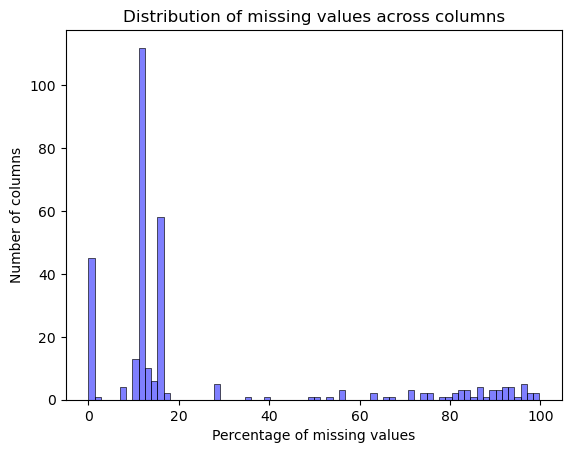

In [22]:
# Plot histograms and overlay them
fig, ax = plt.subplots()
sns.histplot(data=null_percentage, color='blue', alpha=0.5)
# Set the x-label and y-label
plt.xlabel('Percentage of missing values')
plt.ylabel('Number of columns')
# Set the title
plt.title('Distribution of missing values across columns')
# Show the plot
plt.show()
fig.savefig('Distribution of missing values across columns.png', bbox_inches='tight')

Looking the above plot,I am going to erase those columns that have more than 20% of null values

In [23]:
def drop_columns_high_nulls(df, threshold=20):
    
    """
    This function cleans up those columns that exceed a specified threshold of missing values

    Parameters:
    df (dataframe): The dataframe to be filtered.
    threshold (int): the threshold (in percentage) to filter out missing values


    Returns:
    df: the clean dataframe
    
    """
    
    print('Number of fields before: {}'.format(df.shape[1]))
    
    # count the number of NaNs/nulls for each column
    null_counts = df.isnull().sum()
    null_percentage = null_counts*100/len(df)
    null_percentage.sort_values(ascending=False, inplace=True)

    columns_to_drop = null_percentage[null_percentage > threshold]
    df = df.drop(columns=columns_to_drop.index.tolist())
    print('Number of fields after cleaning : {}'.format(df.shape[1]))

    return(df)

In [24]:
azdias = drop_columns_high_nulls(azdias, threshold=20)

Number of fields before: 315
Number of fields after cleaning : 251


### Clean Nans along rows

In [25]:
# count the number of NaNs for every row
nans_per_row = azdias.isna().sum(axis=1)
# calculate the relative value
relative_nans_per_row = nans_per_row*100/azdias.shape[1]
relative_nans_per_row.sort_values(ascending=False,inplace=True)

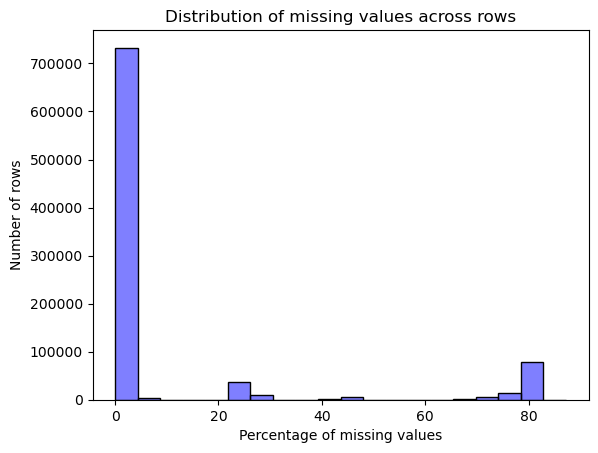

In [26]:
# Plot histograms of nans across rows

fig, ax = plt.subplots()
sns.histplot(data=relative_nans_per_row, color='blue', alpha=0.5,bins=20)
# Customize histogram
plt.title('Histogram of null values along rows')
plt.xlabel('Percentage of missing values')
plt.ylabel('Number of rows')
plt.title('Distribution of missing values across rows')
# Show the plot
plt.show()
fig.savefig('Distribution of missing values across rows.png', bbox_inches='tight')

In [27]:
def drop_rows_high_nulls(df, threshold=30):

    """
    This function cleans up those rows that exceed a specified threshold of missing values

    Parameters:
    df (dataframe): The dataframe to be filtered.
    threshold (int): the threshold (in percentage) to filter out missing values


    Returns:
    df: the clean dataframe
    
    """
    
    print('Number of rows before: {}'.format(df.shape[0]))
    
    # count the number of NaNs for every row
    nans_per_row = df.isna().sum(axis=1)
    # calculate the relative value
    relative_nans_per_row = nans_per_row*100/df.shape[1]
    relative_nans_per_row.sort_values(ascending=False,inplace=True) 
    #filter rows with more than 30% nulls
    rows_to_drop = relative_nans_per_row[relative_nans_per_row > threshold]
    # Drop rows with index values in index_to_remove list
    df = df.drop(index=rows_to_drop.index.tolist())

    print('Number of rows after: {}'.format(df.shape[0]))
    
    return df

In [28]:
azdias = drop_rows_high_nulls(azdias,threshold=70)

Number of rows before: 891221
Number of rows after: 792075


### Check data types

In [29]:
# Loop over columns and print data type
for col in azdias.columns:
    print(f"{col}: {azdias[col].dtype}")

ANZ_HAUSHALTE_AKTIV: float64
ANZ_HH_TITEL: float64
ANZ_PERSONEN: float64
ANZ_TITEL: float64
BALLRAUM: float64
CAMEO_DEU_2015: object
CAMEO_DEUG_2015: object
CJT_GESAMTTYP: float64
CJT_KATALOGNUTZER: float64
CJT_TYP_2: float64
CJT_TYP_3: float64
CJT_TYP_4: float64
CJT_TYP_5: float64
CJT_TYP_6: float64
D19_KONSUMTYP_MAX: int64
EWDICHTE: float64
FINANZ_ANLEGER: int64
FINANZ_HAUSBAUER: int64
FINANZ_MINIMALIST: int64
FINANZ_SPARER: int64
FINANZ_UNAUFFAELLIGER: int64
FINANZ_VORSORGER: int64
FINANZTYP: int64
GEBAEUDETYP: float64
GEBAEUDETYP_RASTER: float64
GEBURTSJAHR: int64
GFK_URLAUBERTYP: float64
GREEN_AVANTGARDE: int64
HEALTH_TYP: float64
HH_EINKOMMEN_SCORE: float64
INNENSTADT: float64
KBA05_ALTER1: float64
KBA05_ALTER2: float64
KBA05_ALTER3: float64
KBA05_ALTER4: float64
KBA05_ANHANG: float64
KBA05_ANTG1: float64
KBA05_ANTG2: float64
KBA05_ANTG3: float64
KBA05_ANTG4: float64
KBA05_AUTOQUOT: float64
KBA05_CCM1: float64
KBA05_CCM2: float64
KBA05_CCM3: float64
KBA05_CCM4: float64
KBA05_DIES

In [30]:
# select variables of type 'object'
categorical_cols = azdias.select_dtypes(include=['object']).columns
categorical_cols

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'OST_WEST_KZ'], dtype='object')

In [31]:
# List of columns with numerical data
#numerical_cols = ['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','GEBURTSJAHR','KBA13_ANZAHL_PKW','MIN_GEBAEUDEJAHR']

# Loop over columns and assign data type
for col in azdias.columns:
    if col in categorical_cols:
        azdias[col] = pd.Categorical(azdias[col])

In [32]:
# Loop over columns and print data type
for col in azdias.columns:
    print(f"{col}: {azdias[col].dtype}")

ANZ_HAUSHALTE_AKTIV: float64
ANZ_HH_TITEL: float64
ANZ_PERSONEN: float64
ANZ_TITEL: float64
BALLRAUM: float64
CAMEO_DEU_2015: category
CAMEO_DEUG_2015: category
CJT_GESAMTTYP: float64
CJT_KATALOGNUTZER: float64
CJT_TYP_2: float64
CJT_TYP_3: float64
CJT_TYP_4: float64
CJT_TYP_5: float64
CJT_TYP_6: float64
D19_KONSUMTYP_MAX: int64
EWDICHTE: float64
FINANZ_ANLEGER: int64
FINANZ_HAUSBAUER: int64
FINANZ_MINIMALIST: int64
FINANZ_SPARER: int64
FINANZ_UNAUFFAELLIGER: int64
FINANZ_VORSORGER: int64
FINANZTYP: int64
GEBAEUDETYP: float64
GEBAEUDETYP_RASTER: float64
GEBURTSJAHR: int64
GFK_URLAUBERTYP: float64
GREEN_AVANTGARDE: int64
HEALTH_TYP: float64
HH_EINKOMMEN_SCORE: float64
INNENSTADT: float64
KBA05_ALTER1: float64
KBA05_ALTER2: float64
KBA05_ALTER3: float64
KBA05_ALTER4: float64
KBA05_ANHANG: float64
KBA05_ANTG1: float64
KBA05_ANTG2: float64
KBA05_ANTG3: float64
KBA05_ANTG4: float64
KBA05_AUTOQUOT: float64
KBA05_CCM1: float64
KBA05_CCM2: float64
KBA05_CCM3: float64
KBA05_CCM4: float64
KBA05_

In [33]:
azdias.dtypes.unique()

array([dtype('float64'),
       CategoricalDtype(categories=['1A', '1B', '1C', '1D', '1E', '2A', '2B', '2C', '2D', '3A',
                         '3B', '3C', '3D', '4A', '4B', '4C', '4D', '4E', '5A', '5B',
                         '5C', '5D', '5E', '5F', '6A', '6B', '6C', '6D', '6E', '6F',
                         '7A', '7B', '7C', '7D', '7E', '8A', '8B', '8C', '8D', '9A',
                         '9B', '9C', '9D', '9E', 'XX'],
       , ordered=False)                                                                        ,
       CategoricalDtype(categories=['1', '2', '3', '4', '5', '6', '7', '8', '9', 'X'], ordered=False),
       dtype('int64'),
       CategoricalDtype(categories=['O', 'W'], ordered=False)],
      dtype=object)

###  Check the number of distinct values

#### Categorical columns

In [34]:
# Count the number of unique values for every column
unique_counts = azdias.select_dtypes(include='category').nunique().sort_values(ascending=False)
# Calculate the percentage of unique values for the top 50 columns
unique_percentages = (unique_counts / len(azdias) * 100)
unique_counts[:25]

CAMEO_DEU_2015     45
CAMEO_DEUG_2015    10
OST_WEST_KZ         2
dtype: int64

#### numerical columns

In [35]:
# Count the number of unique values for every column
unique_counts = azdias.select_dtypes(include=['int64','float64']).nunique().sort_values(ascending=False)
# Calculate the percentage of unique values for the top 50 columns
unique_counts[:20]

KBA13_ANZAHL_PKW         1261
ANZ_HAUSHALTE_AKTIV       292
GEBURTSJAHR               117
LP_LEBENSPHASE_FEIN        41
ANZ_PERSONEN               29
MIN_GEBAEUDEJAHR           29
ANZ_HH_TITEL               21
PRAEGENDE_JUGENDJAHRE      15
LP_LEBENSPHASE_GROB        13
LP_FAMILIE_FEIN            12
GFK_URLAUBERTYP            12
LP_STATUS_FEIN             10
ORTSGR_KLS9                10
WOHNDAUER_2008              9
WOHNLAGE                    8
INNENSTADT                  8
REGIOTYP                    7
SEMIO_DOM                   7
SEMIO_ERL                   7
SEMIO_FAM                   7
dtype: int64

### Data pipeline clustering

In [36]:
# Select all categorical columns
categorical_cols = azdias.select_dtypes(include='category').columns
numerical_cols = azdias.select_dtypes(include=['float64','int64']).columns


# specify imputation methods
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

numeric_transformer = Pipeline(
    steps=[("imputer", num_imputer), 
           ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer",cat_imputer),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)


pipe = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("pca", PCA(n_components=150, random_state=42)),
          ]
)

# Fit the pipeline to the data
pipe.fit(azdias)
# Get the principal components
pca_data = pipe.transform(azdias)

In [37]:
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'BALLRAUM', 'CJT_GESAMTTYP', 'CJT_KATALOGNUTZER', 'CJT_TYP_2',
       'CJT_TYP_3', 'CJT_TYP_4',
       ...
       'SEMIO_TRADV', 'SEMIO_VERT', 'SHOPPER_TYP', 'VERS_T...
       'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=248)),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'OST_WEST_KZ'], dtype='object'))])),
                ('pca', PCA(n_components=150, random_state=42))])

### Elbow plot k-means algorithm

In [38]:
# Calculate within-cluster sum of squares for different values of k

run_elbow_iterations = False

if run_elbow_iterations == True:

    cluster_range = range(1, 20)
    wcss = []

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pca_data)
        wcss.append(kmeans.inertia_)

    # Plot elbow plot
    plt.plot(cluster_range, wcss)
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Within-cluster sum of squares (WCSS)')
    plt.title('Elbow plot')
    # Save the plot as a PNG file
    plt.savefig('Elbow_plot.png')

### PCA variance plot

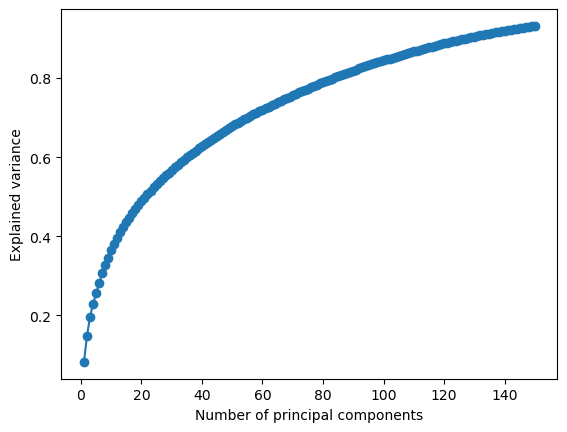

In [39]:
fig, ax = plt.subplots()
explained_variances = pipe.named_steps['pca'].explained_variance_ratio_
# Plot the explained variances against the number of features
plt.plot(np.arange(1, len(explained_variances)+1), np.cumsum(explained_variances), '-o')
plt.xlabel('Number of principal components')
plt.ylabel('Explained variance')
plt.show()
fig.savefig('Explained variance in PCA.png', bbox_inches='tight')

### Creates clustering model

In [40]:
k_opt = 10
kmeans = KMeans(n_clusters=k_opt,random_state=1)
kmeans.fit(pca_data)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10, random_state=1)

### Applies pipeline to general data and plot clusters distributions

/tmp/ipykernel_16966/1434931598.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  azdias['Cluster'] = clusters


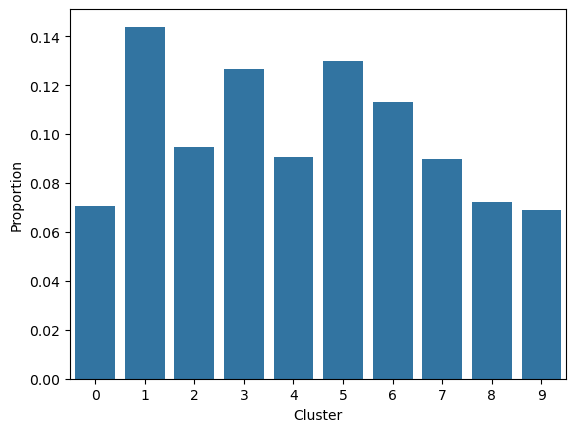

In [41]:
# make clusters predictions on general data
clusters = kmeans.predict(pca_data)

# Assign clusters to azdiaz df
azdias['Cluster'] = clusters

# Group the DataFrame by a column
grouped_azdias = azdias.groupby('Cluster').size().reset_index(name='count')

# Get the total number of observations
total_obs = grouped_azdias['count'].sum()

# Calculate the proportion of each group
grouped_azdias['proportion'] = grouped_azdias['count'] / total_obs

#sort df by cluster values
grouped_azdias = grouped_azdias.sort_values('Cluster')

# Plot a histogram of the proportion using seaborn
sns.barplot(x='Cluster', y='proportion', data=grouped_azdias, color='#1f77b4')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.show()

### Applies pipeline to customers data

/tmp/ipykernel_16966/1303855594.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  customers['Cluster'] = new_clusters


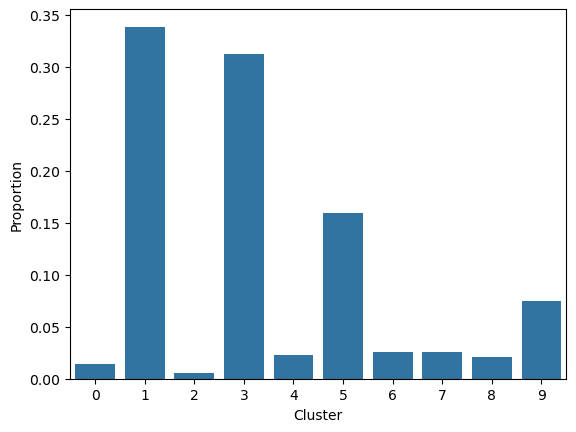

In [42]:
list_features = azdias.columns.tolist()
list_features.remove('Cluster')

# Filter columns selected in axdias df after EDA
customers = customers[list_features]

# replace unknow values
customers = replace_unknown_values(customers)

# Preprocess the new data using the same pipeline as before
pca_data_customers = pipe.transform(customers)

# Predict the clusters for the new data
new_clusters = kmeans.predict(pca_data_customers)

# Add the cluster labels to the original dataframe
customers['Cluster'] = new_clusters

# Group the DataFrame by a column
grouped_customers = customers.groupby('Cluster').size().reset_index(name='count')

# Get the total number of observations
total_obs = grouped_customers['count'].sum()

# Calculate the proportion of each group
grouped_customers['proportion'] = grouped_customers['count'] / total_obs

#sort df by cluster values
grouped_customers = grouped_customers.sort_values('Cluster')

# Plot a histogram of the proportion using seaborn
sns.barplot(x='Cluster', y='proportion', data=grouped_customers, color='#1f77b4')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.show()

### Comparison of cluster distributions

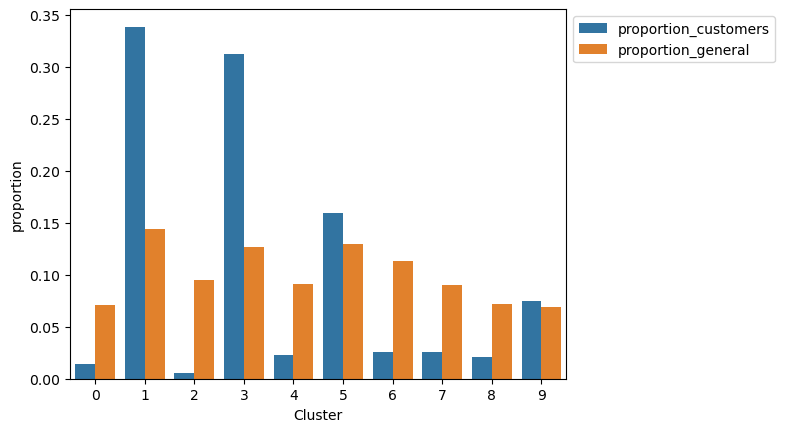

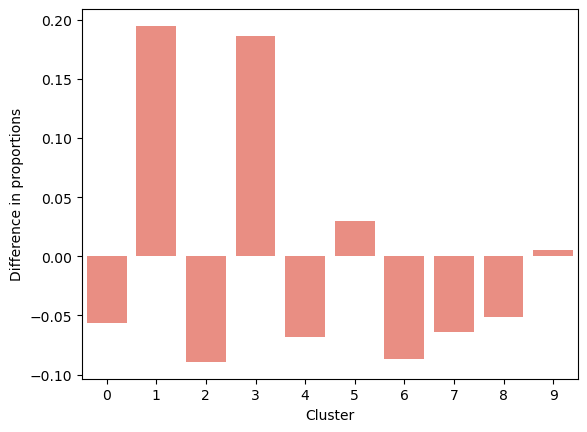

In [43]:
grouped_customers.rename(columns={'count': 'count_customers','proportion':'proportion_customers'},inplace=True)
grouped_azdias.rename(columns={'count': 'count_general','proportion':'proportion_general'},inplace=True)
grouped_join=grouped_customers.merge(grouped_azdias, on='Cluster')
grouped_join['diff_proportions'] = grouped_join['proportion_customers'] - grouped_join['proportion_general']

# melt DataFrame to long format
df_melt = pd.melt(grouped_join, id_vars=['Cluster'], value_vars=['proportion_customers', 'proportion_general'], var_name='Group', value_name='proportion')

#Distribution plots comparison
fig, ax = plt.subplots()
sns.barplot(data=df_melt, x='Cluster', y='proportion', hue='Group')
# assign legend outside plot
ax.legend(title='', loc='upper left', bbox_to_anchor=(1, 1))
fig.savefig('proportion of persons for every cluster.png', bbox_inches='tight')


# create matplotlib axis object
fig, ax = plt.subplots()
# Create the bar plot using seaborn
sns.barplot(x='Cluster', y='diff_proportions', data=grouped_join, color='salmon')
plt.ylabel('Difference in proportions')
plt.xlabel('Cluster')
fig.savefig('difference in proportions of persons for every cluster.png', bbox_inches='tight')

### Feature importance kmeans analysis

In [44]:
# Get the PCA object from the pipeline
pca = pipe.named_steps['pca']

# Get the cluster center for the specified cluster number in the PCA space
cluster_center_pca = kmeans.cluster_centers_[[1,3,2,6]]

# Transform the cluster center back to the original feature space
cluster_center = pca.inverse_transform(cluster_center_pca)

# Get the names of the features after one-hot encoding
categorical_cols = pipe.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder'].get_feature_names_out()
numerical_cols = pipe.named_steps['preprocessor'].named_transformers_['num'].get_feature_names_out()
feature_names = list(numerical_cols) + list(categorical_cols)

In [45]:
# Create a DataFrame to store the feature names and cluster centers
df_cluster_centers = pd.DataFrame({'feature': feature_names, 'cluster1': cluster_center[0], 'cluster3': cluster_center[1], 'cluster2': cluster_center[2],'cluster6': cluster_center[3]})
df_cluster_centers['avg_most_aff'] = df_cluster_centers[['cluster1','cluster3']].mean(axis=1)
df_cluster_centers['avg_less_aff'] = df_cluster_centers[['cluster2','cluster6']].mean(axis=1)
df_cluster_centers['abs_diff'] = abs(df_cluster_centers['avg_most_aff'] - df_cluster_centers['avg_less_aff'])
df_cluster_centers = df_cluster_centers.sort_values(by='abs_diff', ascending=False).reset_index(drop=True)
top_features = df_cluster_centers.head(30)

In [46]:
top_features

,feature,cluster1,cluster3,cluster2,cluster6,avg_most_aff,avg_less_aff,abs_diff
0,FINANZ_SPARER,-0.636246,-0.841855,0.950441,0.814262,-0.739051,0.882352,1.621402
1,CJT_TYP_2,-0.614686,-0.796223,0.988535,0.821926,-0.705455,0.905231,1.610685
2,PRAEGENDE_JUGENDJAHRE,-0.862462,-0.586707,0.694163,0.907987,-0.724584,0.801075,1.525660
3,CJT_TYP_6,0.564561,0.594067,-0.804932,-1.019512,0.579314,-0.912222,1.491536
4,FINANZ_ANLEGER,-0.655359,-0.774068,0.615837,0.935917,-0.714713,0.775877,1.490590
5,FINANZ_VORSORGER,0.807928,0.721379,-0.683198,-0.767847,0.764654,-0.725522,1.490176
6,CJT_TYP_5,0.565421,0.717007,-0.899694,-0.734938,0.641214,-0.817316,1.458530
7,CJT_TYP_3,0.608638,0.616455,-0.851540,-0.808073,0.612546,-0.829806,1.442353
8,SEMIO_RAT,-0.536793,-0.511973,0.651760,1.144780,-0.524383,0.898270,1.422653
9,ALTERSKATEGORIE_GROB,0.671342,0.578123,-0.705446,-0.813732,0.624733,-0.759589,1.384321


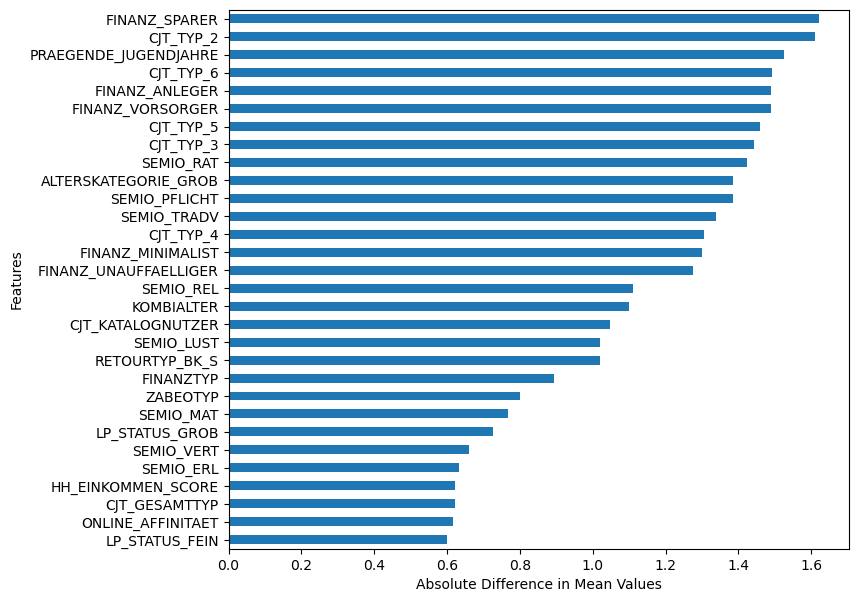

In [47]:
# Create a horizontal bar plot
fig, ax = plt.subplots(figsize=(8, 7))
top_features.plot(x='feature', y='abs_diff', kind='barh', ax=ax, legend=False)
ax.set_xlabel('Absolute Difference in Mean Values')
ax.set_ylabel('Features')
ax.invert_yaxis()
plt.show()

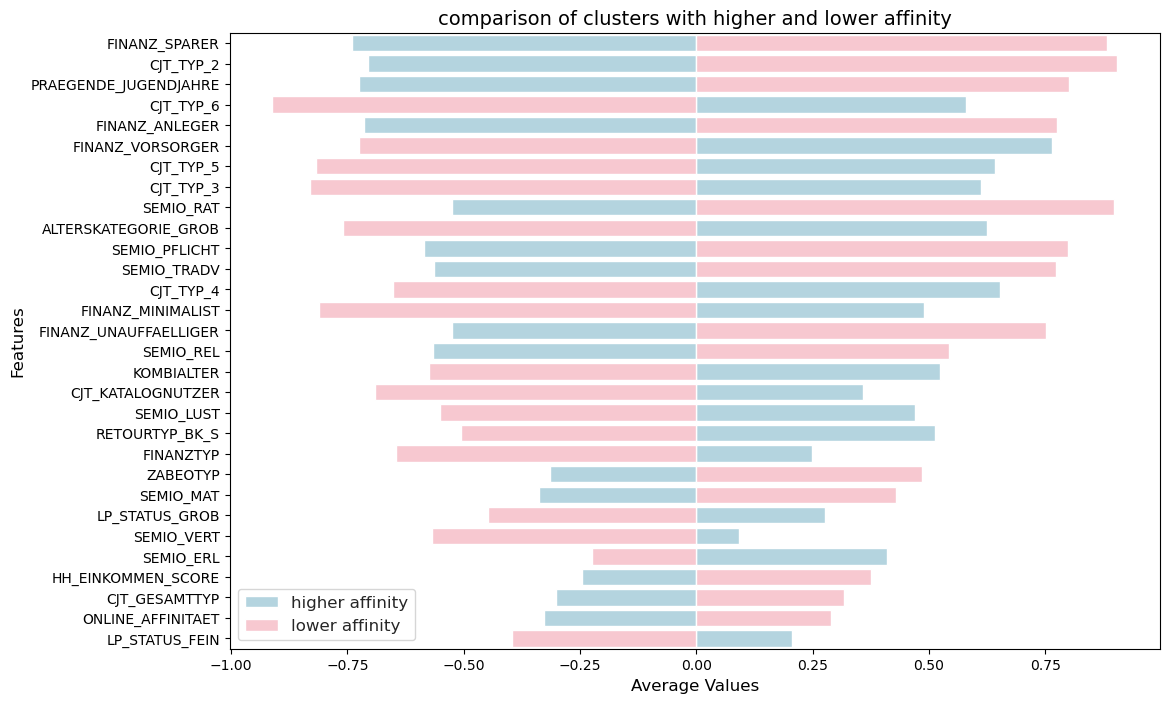

In [48]:
# Create the horizontal bar plot with aligned bars
fig, ax = plt.subplots(figsize=(12, 8))
sns.set_style("whitegrid")
ax1 = sns.barplot(x='avg_most_aff', y='feature', data=top_features, color='lightblue', label='higher affinity')
ax2 = sns.barplot(x='avg_less_aff', y='feature', data=top_features, color='pink', label='lower affinity')
plt.title('comparison of clusters with higher and lower affinity', fontsize=14)
plt.xlabel('Average Values', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.legend(fontsize=12)  # Add a legend
plt.show()
fig.savefig('Driver variables of prospect clients.png', bbox_inches='tight')

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [49]:
#data_keys
data_key_train = 'Udacity_MAILOUT_052018_TRAIN.csv'
data_location_train = 's3://{}/{}'.format(bucket, data_key_train)
mailout_train = pd.read_csv(data_location_train, sep=';')

/tmp/ipykernel_16966/1587515949.py:4: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv(data_location_train, sep=';')


In [50]:
mailout_train.shape

(42962, 367)

### Check for unbalanced data

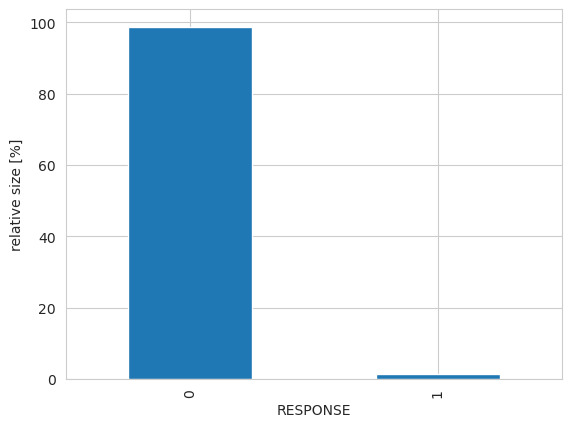

In [51]:
# group by the 'category' column and count the number of occurrences
counts = mailout_train.groupby('RESPONSE').size()
# calculate the relative size of each group
relative_sizes = counts*100 / counts.sum()
# plot the results in a bar chart
fig, ax = plt.subplots()
relative_sizes.plot.bar()
plt.ylabel('relative size [%]')
plt.show()
fig.savefig('class imbalances.png', bbox_inches='tight')

In [52]:
counts

RESPONSE
0    42430
1      532
dtype: int64

In [53]:
relative_sizes

RESPONSE
0    98.761696
1     1.238304
dtype: float64

### Replace unknown values with NaNs

In [54]:
mailout_train = replace_unknown_values(mailout_train)

### Check unknow values count for every single column

In [55]:
# count the number of NaNs/nulls for each column
null_counts = mailout_train.isnull().sum()
null_percentage = null_counts*100/len(mailout_train)
null_percentage.sort_values(ascending=False, inplace=True)

for index, col in null_percentage.items():
    print('{} - {}%'.format(index, round(col)))

ALTER_KIND4 - 100%
ALTER_KIND3 - 100%
TITEL_KZ - 100%
D19_TELKO_ONLINE_DATUM - 99%
ALTER_KIND2 - 98%
D19_BANKEN_LOKAL - 98%
D19_BANKEN_OFFLINE_DATUM - 96%
D19_DIGIT_SERV - 96%
D19_TELKO_ANZ_12 - 96%
ALTER_KIND1 - 95%
D19_TIERARTIKEL - 95%
D19_BANKEN_ANZ_12 - 94%
D19_BANKEN_REST - 93%
D19_GARTEN - 92%
D19_TELKO_ANZ_24 - 92%
D19_VERSI_ANZ_12 - 92%
D19_TELKO_OFFLINE_DATUM - 91%
D19_ENERGIE - 91%
D19_BANKEN_GROSS - 90%
D19_BANKEN_ANZ_24 - 90%
D19_NAHRUNGSERGAENZUNG - 90%
D19_BIO_OEKO - 89%
D19_TELKO_REST - 88%
D19_FREIZEIT - 88%
D19_SCHUHE - 87%
D19_VERSI_ANZ_24 - 87%
D19_LEBENSMITTEL - 87%
D19_WEIN_FEINKOST - 86%
D19_BANKEN_ONLINE_DATUM - 86%
D19_BANKEN_DIREKT - 86%
D19_DROGERIEARTIKEL - 85%
D19_VERSAND_REST - 85%
D19_TELKO_MOBILE - 84%
D19_BEKLEIDUNG_GEH - 84%
D19_RATGEBER - 82%
D19_BILDUNG - 81%
D19_BANKEN_DATUM - 79%
D19_KINDERARTIKEL - 79%
D19_TELKO_DATUM - 78%
D19_VERSICHERUNGEN - 75%
D19_SAMMELARTIKEL - 74%
D19_HANDWERK - 72%
D19_BEKLEIDUNG_REST - 70%
D19_KOSMETIK - 67%
D19_HAUS_DEK

<AxesSubplot: ylabel='Count'>

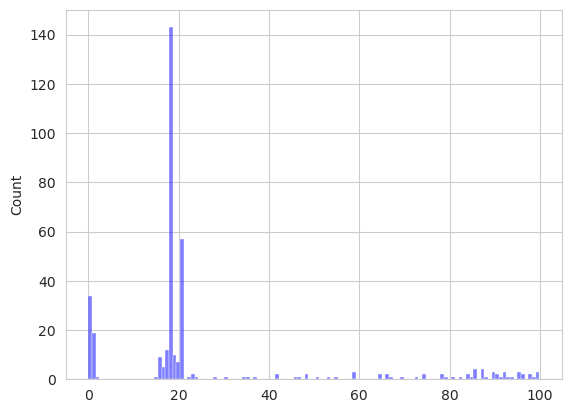

In [56]:
# Plot histograms and overlay them
sns.histplot(data=null_percentage, color='blue', alpha=0.5)

In [57]:
mailout_train = drop_columns_high_nulls(mailout_train, threshold=20)

Number of fields before: 367
Number of fields after cleaning : 235


### Compare plots to find key variables

In [58]:
run_comparison_plots = False

if run_comparison_plots == True:
    
    for col in mailout_train.columns:
        if col not in ['LNR', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR','RESPONSE']:
            prueba_grafico = mailout_train.groupby([col,'RESPONSE']).agg({'LNR':'count'}).reset_index()
            prueba_grafico['proportion'] = np.where(prueba_grafico['RESPONSE'] == 1, np.round(prueba_grafico['LNR']*100/counts[1]), np.round(prueba_grafico['LNR']*100/counts[0]))
            print(col)
            fig, ax = plt.subplots()
            sns.barplot(data=prueba_grafico, x=col, y='proportion', hue='RESPONSE')
            plt.show()

### Check columns with a lot of distinct values 

In [59]:
# Count the number of unique values for every column
unique_counts = mailout_train.nunique().sort_values(ascending=False)
# Calculate the percentage of unique values for the top 50 columns
#unique_percentages = (unique_counts / len(mailout_train) * 100)
unique_counts[:25]

LNR                            42962
EINGEFUEGT_AM                   1599
KBA13_ANZAHL_PKW                1230
ANZ_HAUSHALTE_AKTIV              175
ANZ_STATISTISCHE_HAUSHALTE       173
GEBURTSJAHR                      108
VERDICHTUNGSRAUM                  46
CAMEO_DEU_2015                    45
CAMEO_INTL_2015                   43
LP_LEBENSPHASE_FEIN               41
D19_LETZTER_KAUF_BRANCHE          35
EINGEZOGENAM_HH_JAHR              33
MIN_GEBAEUDEJAHR                  31
ALTERSKATEGORIE_FEIN              25
CAMEO_DEUG_2015                   19
ANZ_HH_TITEL                      15
PRAEGENDE_JUGENDJAHRE             15
ANZ_PERSONEN                      14
VK_DISTANZ                        13
LP_LEBENSPHASE_GROB               13
GFK_URLAUBERTYP                   12
LP_FAMILIE_FEIN                   12
D19_GESAMT_ONLINE_QUOTE_12        11
D19_VERSAND_ONLINE_QUOTE_12       11
VK_DHT4A                          11
dtype: int64

### Drops columns with more than 1000 different values

In [60]:
mailout_train = mailout_train.drop(['LNR','EINGEFUEGT_AM', 'KBA13_ANZAHL_PKW'], axis=1)

### Check for NANs along rows

In [61]:
# count the number of NaNs for every row
nans_per_row = mailout_train.isna().sum(axis=1)
# calculate the relative value
relative_nans_per_row = nans_per_row*100/mailout_train.shape[1]
relative_nans_per_row.sort_values(ascending=False,inplace=True)

Text(0, 0.5, 'Number of rows')

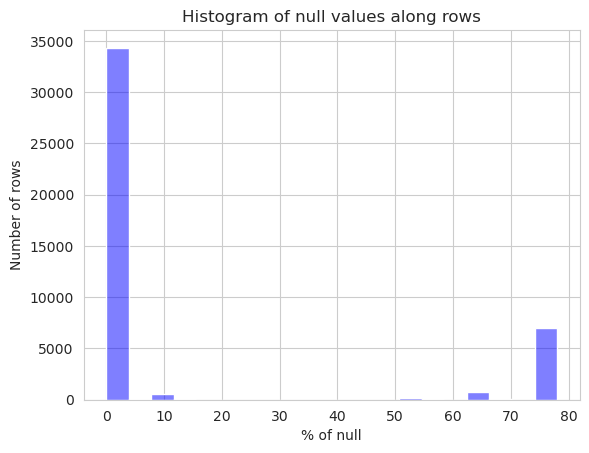

In [62]:
# Plot histograms and overlay them
sns.histplot(data=relative_nans_per_row, color='blue', alpha=0.5,bins=20)
# Customize histogram
plt.title('Histogram of null values along rows')
plt.xlabel('% of null')
plt.ylabel('Number of rows')

In [63]:
mailout_train = drop_rows_high_nulls(mailout_train, threshold=70)

Number of rows before: 42962
Number of rows after: 35975


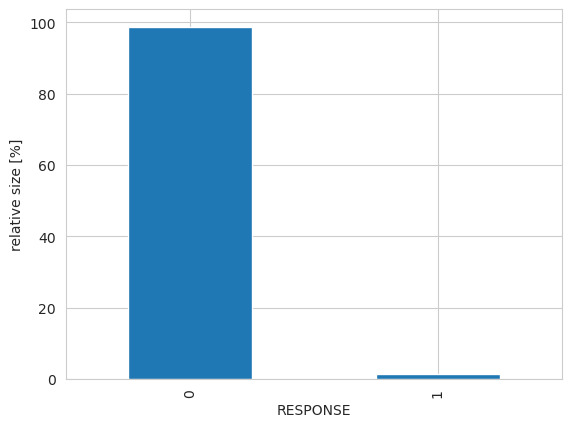

In [64]:
# group by the 'category' column and count the number of occurrences
counts = mailout_train.groupby('RESPONSE').size()
# calculate the relative size of each group
relative_sizes = counts*100 / counts.sum()
# plot the results in a bar chart
relative_sizes.plot.bar()
plt.ylabel('relative size [%]')
plt.show()

In [65]:
counts

RESPONSE
0    35526
1      449
dtype: int64

In [66]:
relative_sizes

RESPONSE
0    98.751911
1     1.248089
dtype: float64

### Solve for some number details

In [67]:
mailout_train['CAMEO_DEUG_2015'] = mailout_train['CAMEO_DEUG_2015'].astype(str).str.replace(r'\..*', '', regex=True)
mailout_train['CAMEO_INTL_2015'] = mailout_train['CAMEO_INTL_2015'].astype(str).str.replace(r'\..*', '', regex=True)
print(mailout_train['CAMEO_DEUG_2015'].unique())
print(mailout_train['CAMEO_INTL_2015'].unique())

['5' '2' '7' '4' '3' '6' '1' '8' '9' 'nan' 'X']
['34' '32' '14' '41' '24' '33' '25' '31' '22' '43' '13' '55' '23' '54'
 '51' '45' 'nan' '12' '44' '35' '15' '52' 'XX']


### Check for data types

In [68]:
categorical_cols = mailout_train.select_dtypes(include=['object']).columns
categorical_cols

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ'],
      dtype='object')

In [69]:
# Loop over columns and assign data type
for col in mailout_train.columns:
    if col in categorical_cols:
        mailout_train[col] = pd.Categorical(mailout_train[col])

In [70]:
mailout_train.dtypes.unique()

array([dtype('float64'),
       CategoricalDtype(categories=['1A', '1B', '1C', '1D', '1E', '2A', '2B', '2C', '2D', '3A',
                         '3B', '3C', '3D', '4A', '4B', '4C', '4D', '4E', '5A', '5B',
                         '5C', '5D', '5E', '5F', '6A', '6B', '6C', '6D', '6E', '6F',
                         '7A', '7B', '7C', '7D', '7E', '8A', '8B', '8C', '8D', '9A',
                         '9B', '9C', '9D', '9E', 'XX'],
       , ordered=False)                                                                        ,
       CategoricalDtype(categories=['1', '2', '3', '4', '5', '6', '7', '8', '9', 'X', 'nan'], ordered=False),
       CategoricalDtype(categories=['12', '13', '14', '15', '22', '23', '24', '25', '31', '32',
                         '33', '34', '35', '41', '43', '44', '45', '51', '52', '54',
                         '55', 'XX', 'nan'],
       , ordered=False)                                                                        ,
       dtype('int64'),
       Categori

### Train test split

In [71]:
X = mailout_train.loc[:, mailout_train.columns != 'RESPONSE']
y = mailout_train['RESPONSE']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

### Preprocessing pipeline

In [72]:
numerical_cols = X_train.select_dtypes(include=['float64','int64']).columns

# specify imputation methods
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

numeric_transformer = Pipeline(
    steps=[("imputer", num_imputer), 
           ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer",cat_imputer),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

### Resample tecniques comparison

In [ ]:
#different models:
models = {
    'Logistic regression': LogisticRegression(max_iter=1000),
    'Random Forest Classifier': RandomForestClassifier(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'XG Boost': xgb.XGBClassifier()
    }

# define the resampling techniques to compare
resampling_techniques = {
    'No Resampling': None,
    'Random OverSampler': RandomOverSampler(random_state=42),
    'Random UnderSampler': RandomUnderSampler(random_state=42),
    'SMOTE': SMOTE(random_state=42)
}


results = {}

for model_name, model in models.items():
    print(model_name)
    results[model_name] = {}
    for resampler_name, resampler in resampling_techniques.items():
        print(resampler_name)

        if resampler is None:
            slm_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                           ("classifier", model),
                                          ])
            slm_pipeline.fit(X_train, y_train)
            y_pred = slm_pipeline.predict(X_test)
            auc = roc_auc_score(y_test, y_pred)
        else:
            slm_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                            ('resample', resampler),
                                            ("classifier", model),
                                           ])
            slm_pipeline.fit(X_train, y_train)
            y_pred = slm_pipeline.predict(X_test)
            auc = roc_auc_score(y_test, y_pred)
        
        results[model_name][resampler_name] = auc
                    

# Fit the pipeline to the data
results

Logistic regression
No Resampling
Random OverSampler
Random UnderSampler
SMOTE
Random Forest Classifier
No Resampling
Random OverSampler
Random UnderSampler
SMOTE
Gradient Boosting Classifier
No Resampling
Random OverSampler
Random UnderSampler
SMOTE
XG Boost
No Resampling
Random OverSampler
Random UnderSampler
SMOTE


{'Logistic regression': {'No Resampling': 0.5,
  'Random OverSampler': 0.6006606061869714,
  'Random UnderSampler': 0.6247082699137494,
  'SMOTE': 0.5888725561741136},
 'Random Forest Classifier': {'No Resampling': 0.5,
  'Random OverSampler': 0.49995308688309253,
  'Random UnderSampler': 0.7107298985981666,
  'SMOTE': 0.5},
 'Gradient Boosting Classifier': {'No Resampling': 0.49976543441546256,
  'Random OverSampler': 0.7050874669001899,
  'Random UnderSampler': 0.7674582820764093,
  'SMOTE': 0.4992493901294802},
 'XG Boost': {'No Resampling': 0.5,
  'Random OverSampler': 0.49943704259711014,
  'Random UnderSampler': 0.7445792762174823,
  'SMOTE': 0.5}}

In [ ]:
df_results = pd.DataFrame.from_dict(results)
df_results

,Logistic regression,Random Forest Classifier,Gradient Boosting Classifier,XG Boost
No Resampling,0.500000,0.500000,0.499765,0.500000
Random OverSampler,0.600661,0.499953,0.705087,0.499437
Random UnderSampler,0.624708,0.710730,0.767458,0.744579
SMOTE,0.588873,0.500000,0.499249,0.500000


### Cross-validation

In [ ]:
slm_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                ('resample', RandomUnderSampler(random_state=42)),
                                ("classifier", GradientBoostingClassifier(random_state=42)),
                               ])

# Perform 5-fold cross-validation and calculate the mean AUC
scores = cross_val_score(slm_pipeline, X, y, cv=5, scoring='roc_auc')
mean_auc = scores.mean()
std_auc = scores.std()

print("Mean AUC: {:.3f} with standard deviation : {:.3f}".format(mean_auc,std_auc))

Mean AUC: 0.759 with standard deviation : 0.015


### Tunning of hyperparameters

In [ ]:
slm_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                ('resample', RandomUnderSampler(random_state=42)),
                                ("classifier", GradientBoostingClassifier(random_state=42)),
                               ])

# Define the hyperparameters to search over
param_grid = {
    'classifier__learning_rate': [0.01, 0.1, 0.5],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 7]
}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(slm_pipeline, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'ANZ_HAUSHALTE_AKTIV',
       'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL', 'ARBEIT', 'BALLRAUM',
       ...
       'VHA'...
                                                                         Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ'],
      dtype='object'))])),
                                       ('resample',
                                        RandomUnderSampler(random_state=42)),
                                       ('classifier',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.5],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [50, 100, 200]},
             scoring='roc_auc')

In [ ]:
# Get the best hyperparameters and AUC score
best_params = grid_search.best_params_
best_auc = grid_search.best_score_

# Fit the pipeline on the entire dataset using the best hyperparameters
slm_pipeline.set_params(**best_params)
slm_pipeline.fit(X, y)

# Make predictions and calculate AUC score
y_pred = slm_pipeline.predict(X_test)
auc = roc_auc_score(y_test, y_pred)

print("Best hyperparameters:", best_params)
print("Best AUC score:", best_auc)
print("Test AUC score:", auc)

Best hyperparameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Best AUC score: 0.7549624552886097
Test AUC score: 0.7945990839779544


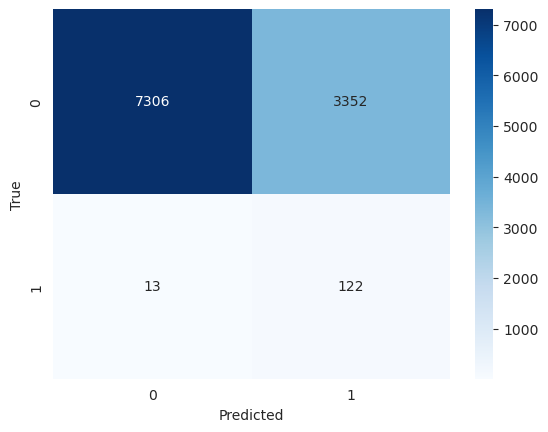

In [ ]:
# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Model interpretation results

#### Feature importances

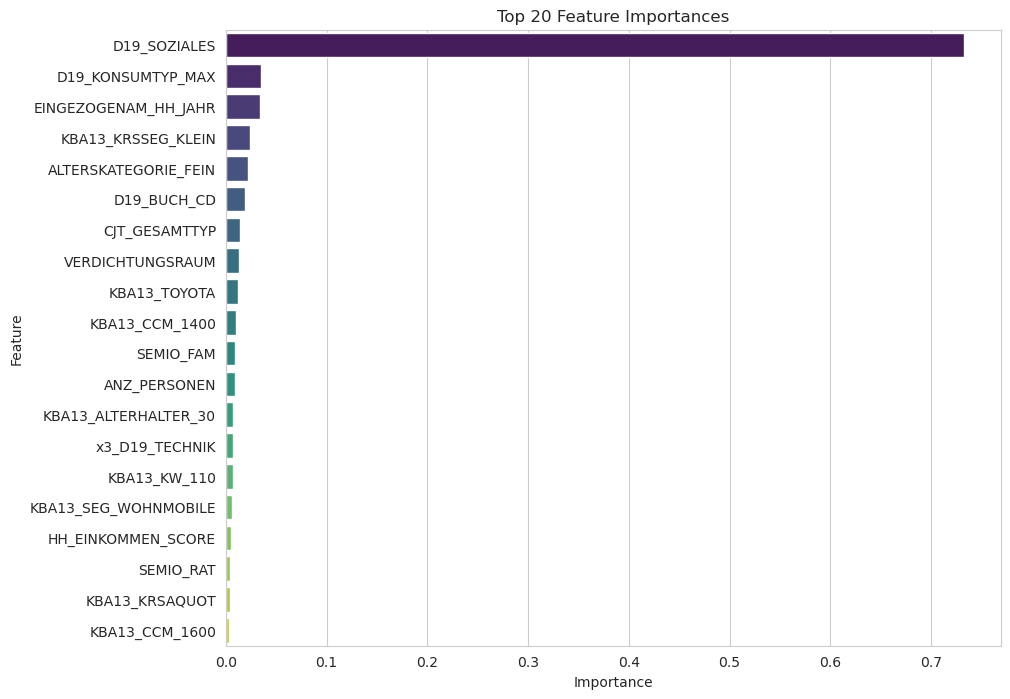

In [ ]:
importances = slm_pipeline.named_steps['classifier'].feature_importances_
    
# Get the names of the features after one-hot encoding
categorical_cols = slm_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder'].get_feature_names_out()
numerical_cols = slm_pipeline.named_steps['preprocessor'].named_transformers_['num'].get_feature_names_out()
feature_names = list(numerical_cols) + list(categorical_cols)

# Create a pandas dataframe with feature names and importances
feature_importances_df = pd.DataFrame({"Feature": feature_names, "Importance": importances}).sort_values(by="Importance", ascending=False)


# Plot the top 20 features by importance as a horizontal bar plot
top_features = feature_importances_df.head(20)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=top_features, palette="viridis", orient="h")
plt.title("Top 20 Feature Importances")
plt.show()
fig.savefig('Top 20 feature importances.png', bbox_inches='tight')

In [ ]:
top_features

,Feature,Importance
23,D19_SOZIALES,0.732775
22,D19_KONSUMTYP_MAX,0.035160
31,EINGEZOGENAM_HH_JAHR,0.033841
119,KBA13_KRSSEG_KLEIN,0.024010
1,ALTERSKATEGORIE_FEIN,0.021584
19,D19_BUCH_CD,0.019069
10,CJT_GESAMTTYP,0.014295
214,VERDICHTUNGSRAUM,0.013077
160,KBA13_TOYOTA,0.011788
73,KBA13_CCM_1400,0.010325


In [ ]:
# Calculate the correlation coefficients

# Preprocess the data
X_processed = preprocessor.transform(X)

# Convert the output dataset to a DataFrame
output_df = pd.DataFrame(X_processed, columns=feature_names)

# Calculate the correlation coefficients
correlations = output_df.corr()['D19_SOZIALES'].drop('D19_SOZIALES')

# Get the top 10 absolute correlation values
x = 10
top_x = correlations.abs().nlargest(x)

# Print the top x correlation values with corresponding signs
for col in top_x.index:
    sign = '+' if correlations[col] > 0 else '-'
    print(f"{sign} {col}: {np.round(correlations[col],3)}")

- VK_ZG11: -0.17200000000000001
- VK_DISTANZ: -0.164
- D19_KONSUMTYP: -0.163
- VK_DHT4A: -0.126
+ VHA: 0.1
+ D19_BUCH_CD: 0.096
- RT_SCHNAEPPCHEN: -0.079
+ LP_STATUS_GROB: 0.062
+ LP_STATUS_FEIN: 0.061
- ZABEOTYP: -0.06


### Make predictions on test set

In [ ]:
#data_keys
data_key_test = 'Udacity_MAILOUT_052018_TEST.csv'
data_location_test = 's3://{}/{}'.format(bucket, data_key_test)
mailout_test = pd.read_csv(data_location_test, sep=';')
mailout_test.shape

/tmp/ipykernel_16966/3709764438.py:4: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv(data_location_test, sep=';')


(42833, 366)

In [ ]:
mailout_test = replace_unknown_values(mailout_test)

In [ ]:
y_pred_test_set = slm_pipeline.predict(mailout_test)
mailout_test['RESPONSE'] = y_pred_test_set

/tmp/ipykernel_16966/2016630167.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mailout_test['RESPONSE'] = y_pred_test_set


In [86]:
mailout_test.groupby('RESPONSE').agg({'LNR':'count'}).reset_index()

,RESPONSE,LNR
0,0,24384
1,1,18449
